Welcome to week 8 of the seminar! This is the final week dedicated to introducing new methods before we shift our focus to your final paper assignments. 

This week, we will delve into advanced techniques for variable selection and assessment of variable importance using Lasso and ElasticNet regression methods. In financial modeling and prediction, selecting the most relevant variables is crucial for creating accurate and robust models. Lasso (Least Absolute Shrinkage and Selection Operator) and ElasticNet are powerful tools that not only perform regularization to prevent overfitting but also enable automatic variable selection by shrinking some coefficients entirely to zero. These techniques help in identifying the most significant predictors out of a large set of potential variables.

# Python Package Imports

In [1]:
import pandas as pd
import numpy as np

# the SciKit Learn library contains many useful functions for Machine Learning applications
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

from plotnine import ggplot, aes, geom_line, geom_point, theme_minimal, geom_text, scale_x_date, theme, geom_ribbon, labs, \
                        scale_x_log10, geom_bar, element_text, coord_flip

# Sentiment Indicators and Cryptocurrency Returns

This week's research project will leverage market sentiment data from MarketPsych and return data from CoinMarketCap to analyze cryptocurrencies. Using the ElasticNet regression method, we aim to identify the most important predictors from a comprehensive set of over 50 MarketPsych variables.

Cryptocurrencies are known for their high volatility and sensitivity to market sentiment. MarketPsych provides a rich dataset of sentiment indicators, capturing various aspects of market emotions and perceptions through extensive text analysis of news, social media, and other sources. These sentiment variables can potentially influence cryptocurrency returns significantly, offering a unique opportunity to explore the interplay between sentiment and market performance.

In this project, you will apply ElasticNet regression, a versatile technique that combines the properties of Lasso and Ridge regression, to handle variable selection and regularization. ElasticNet is particularly useful when dealing with datasets that have a large number of predictors and potential multicollinearity among them. By using ElasticNet, we can effectively shrink some coefficients to zero, thereby selecting only the most relevant predictors and improving the model's interpretability and predictive performance.

Our objective is to determine which MarketPsych sentiment variables are the most significant predictors of cryptocurrency returns. This analysis will not only provide insights into the factors driving cryptocurrency market movements but also demonstrate the power of advanced regression techniques in handling complex and high-dimensional datasets.

## Loading Data from GitHub

The data sources for this week are proprietary and available with paid subscription only, therefore I have prepared data files in binary  format that you can read into a pandas dataframe with the following commands. 

In [2]:
historical_returns = pd.read_parquet('https://github.com/emekelburg/DUEPHDFINMETHODS2024/raw/main/ETH_historical_returns.parquet')

In [3]:
historical_sentiment = pd.read_parquet('https://github.com/emekelburg/DUEPHDFINMETHODS2024/raw/main/ETH_historical_sentiment.parquet')

The first four columns in the historical sentiment data are index and volume type columns, everything after that is a unique sentiment dimension.   These are the definitions of the sentiment variables in detail, including their numerical domains. 

| Index                   | Description                                                                | Range          |
|-------------------------|----------------------------------------------------------------------------|----------------|
| sentiment               | overall positive references, net of negative references                    | -1 to 1        |
| negative                | overall negative references                                                | 0 to 1*        |
| positive                | overall positive references                                                | 0 to 1*        |
| optimism                | references connoting optimism, future-tense positive                       | 0 to 1*        |
| pessimism               | references connoting pessimism, future-tense negative                      | 0 to 1*        |
| joy                     | happiness and affection                                                    | 0 to 1*        |
| loveHate                | love, net of references to hate                                            | -1 to 1        |
| trust                   | trustworthiness, net of references connoting corruption                    | -1 to 1        |
| anger                   | anger and disgust                                                          | 0 to 1*        |
| disagreement            | dispute net of agreement and conciliation                                  | -1 to 1        |
| fear                    | fear and anxiety                                                           | 0 to 1*        |
| gloom                   | gloom and negative future outlook                                          | 0 to 1*        |
| stress                  | arousal and intensity, weighted towards distress                           | 0 to 1*        |
| violence                | violent crime, terrorism, and war                                          | 0 to 1*        |
| surprise                | unexpected events and surprise                                             | 0 to 1*        |
| timeUrgency             | urgency and timeliness, net of references to tardiness and delays          | -1 to 1        |
| uncertainty             | uncertainty and confusion                                                  | 0 to 1*        |
| emotionVsFact           | all emotional sentiments, net of all factual and topical references        | -1 to 1        |
| shortVsLongTerm         | references to immediate and short-term timeframes versus long term         | -1 to 1        |
| marketRisk              | positive emotionality and positive expectations net of negative emotionality and negative expectations. Includes factors from social media found characteristic of speculative bubbles            | -1 to 1        |
| longShort               | buying, net of references to shorting or selling                           | -1 to 1        |
| longShortForecast       | forecasts of buying, net of references to forecasts of shorting or selling | -1 to 1        |
| priceDirection          | price increases, net of references to price decreases                      | -1 to 1        |
| priceDown               | references to price decreases                                              | 0 to 1*        |
| priceForecast           | forecasts of asset price rises, net of references to forecasts of drops    | -1 to 1        |
| priceUp                 | asset price increases                                                      | 0 to 1*        |
| priceMomentum           | currency price trend strength, net of references to trend weakness         | -1 to 1        |
| topVsBottom             | net references to asset price topping, expensive valuations, and excessive speculation versus bottoming and relatively inexpensive prices          | -1 to 1        |
| overvaluedVsUndervalued | references to expensively versus cheaply valued asset prices               | -1 to 1        |
| volatility              | volatility in market prices or business conditions                         | 0 to 1*        |
| adoption                | acceptance and widespread adoption                                         | 0 to 1*        |
| adoptionForecast        | forecasts of acceptance and widespread adoption                            | 0 to 1*        |
| anonymity               | user anonymity in transactions                                             | 0 to 1*        |
| attack                  | hacks and other cyberattacks related to the coin                           | 0 to 1*        |
| codeSentiment           | overall positive references to the code base, net of negative references   | -1 to 1        |
| codeUpgrade             | code upgrades and enhancements                                             | 0 to 1*        |
| criminalActivity        | criminal activity involving the cryptocurrency or community                | 0 to 1*        |
| developerSentiment      | overall positive references to the development team, net of negative refs  | 0 to 1*        |
| fOMO                    | fear of missing out                                                        | 0 to 1*        |
| fork                    | fork in the blockchain                                                     | 0 to 1*        |
| forkForecast            | forecasts of a fork in the blockchain                                      | 0 to 1*        |
| hodl                    | holding on for dear life                                                   | 0 to 1*        |
| innovation              | innovativeness                                                             | 0 to 1*        |
| litigation              | litigation and lawsuits involving the cryptocurrency or community          | 0 to 1*        |
| majorityAttack          | majority of miners attacking the blockchain                                | 0 to 1*        |
| noobs                   | amateur and naive investor activity                                        | 0 to 1*        |
| regulatoryCrackdown     | regulatory crackdown on cryptocurrency-related activities                  | 0 to 1*        |
| regulatoryIssues        | tax or securities authority’s intervention or legislation                  | 0 to 1*        |
| scam                    | fraudulent activity or references to scams associated with the crypto      | 0 to 1*        |
| transactionSpeed        | fast versus slow transactions speeds for the cryptocurrency                | -1 to 1        |
| vulnerability           | vulnerabilities or weaknesses in the code                                  | 0 to 1*        |
| partnership             | references to collaborations                                               | 0 to 1*        |
| futureVsPast            | references to future events, net of references to past                     | -1 to 1        |

In [8]:
historical_sentiment.head(3)

,assetcode,datatype,mentions,buzz,sentiment,negative,positive,optimism,pessimism,joy,...,litigation,majorityattack,noobs,regulatorycrackdown,regulatoryissues,scam,transactionspeed,vulnerability,partnership,futurevspast
date,,,,,,,,,,,,,,,,,,,,,
2015-08-07,ETHEREUM,News_Social,22.0,50.0,0.350000,0.150000,0.500000,0.040000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.020000,NaN,0.020000,NaN,-0.240000
2015-08-08,ETHEREUM,News_Social,26.0,69.6,0.165230,0.186782,0.352011,0.028736,0.043103,0.014368,...,NaN,NaN,NaN,NaN,NaN,0.043103,NaN,NaN,NaN,-0.127874
2015-08-09,ETHEREUM,News_Social,62.0,243.0,-0.119342,0.364198,0.244856,0.043210,0.086420,0.008230,...,NaN,NaN,NaN,NaN,NaN,0.162551,NaN,0.002058,NaN,0.084362


In [9]:
# collect the names of the sentiment variable columns
sentiment_types = historical_sentiment.columns[4:]

In [11]:
sentiment_types

Index(['sentiment', 'negative', 'positive', 'optimism', 'pessimism', 'joy',
       'lovehate', 'trust', 'anger', 'disagreement', 'fear', 'gloom', 'stress',
       'violence', 'surprise', 'timeurgency', 'uncertainty', 'emotionvsfact',
       'shortvslongterm', 'marketrisk', 'longshort', 'longshortforecast',
       'pricedirection', 'pricedown', 'priceforecast', 'priceup',
       'pricemomentum', 'topvsbottom', 'overvaluedvsundervalued', 'volatility',
       'adoption', 'adoptionforecast', 'anonymity', 'attack', 'codesentiment',
       'codeupgrade', 'criminalactivity', 'developersentiment', 'fomo', 'fork',
       'forkforecast', 'hodl', 'innovation', 'litigation', 'majorityattack',
       'noobs', 'regulatorycrackdown', 'regulatoryissues', 'scam',
       'transactionspeed', 'vulnerability', 'partnership', 'futurevspast'],
      dtype='object')

Many of the variable have NaN values in the table, and for this research we set them to zero, because unlike other machine learning methods  (such as tree-based algorithsm), ElasticNet does not have a methodical way to deal with these types of values. 

We also merge the data with the returns, so we have X and y variables in the same data frame. 

In [12]:
sentiment_df = ( 
    historical_sentiment
     .get(sentiment_types)
     .fillna(0)
     .join(historical_returns)
     .dropna()
)

## Machine Learning Model to Understand Predictor Importance

In this section, we will explore how to use a machine learning technique to understand the importance of different predictors in forecasting cryptocurrency returns. Specifically, we will focus on using the ElasticNet model, a powerful tool that combines the properties of both Lasso and Ridge regression to handle multicollinearity and feature selection effectively. This process involves several critical steps: feature engineering, model creation, hyperparameter tuning, and the interpretation of variable importance through visual plots.

### Feature Engineering

Feature engineering is a crucial step in preparing our dataset for machine learning modeling, especially when dealing with complex data like cryptocurrency returns influenced by sentiment variables. The goal is to transform raw data into a format that enhances the performance of our model. In this case, our dataset consists of various sentiment metrics derived from MarketPsych data, along with cryptocurrency returns data from CoinMarketCap.

First, we prepare the data by selecting the appropriate features and target variable. Here, we use all columns except 'ETH daily return' as our features (X) and set 'ETH daily return' as our target variable (y). This allows the model to learn the relationship between sentiment metrics and daily returns of Ethereum.

Next, we standardize the features using StandardScaler. Standardization is essential because it ensures that each feature contributes on a comparable scale to the model (achieved by scaling them to have a mean of 0 and a standard deviation of 1). This is particularly important for machine learning methods (like ElasticNet), which tend to be very sensitive to the scale of input data and perform better when features are standardized.

After standardizing the features, we split the data into training and testing sets using an 80-20 split. This means 80% of the data is used for training the model, while the remaining 20% is reserved for testing its performance. The random_state parameter ensures that the split is reproducible, allowing for consistent results in repeated runs.

In [56]:
# Prepare data
X = sentiment_df.drop(columns=['ETH daily return'])  # Features: all columns except the target
y = sentiment_df['ETH daily return']  # Target: ETH daily returns

# Standardizing the features - most machine learning methods are sensible to distributions and appreciate standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


### Creating an ElasticNet Model

Creating an ElasticNet model involves setting two crucial hyperparameters: alpha and the L1-ratio. These parameters control the regularization applied to the model, balancing between overfitting and underfitting, and determining the mix of L1 (Lasso) and L2 (Ridge) regularization techniques.

Alpha is the primary regularization parameter in ElasticNet. It controls the overall strength of the regularization applied to the model:
- A higher alpha increases the regularization strength, adding a penalty to the size of the coefficients. This helps to prevent overfitting by discouraging overly complex models that fit the training data too closely. However, setting alpha too high can lead to underfitting, where the model is too simple to capture the underlying patterns in the data.
- A lower alpha reduces the regularization effect, allowing the model coefficients to grow larger. While this can improve the model's fit to the training data, it also increases the risk of overfitting, where the model captures noise along with the signal.

L1-ratio determines the mix of L1 and L2 regularization in the ElasticNet model:
- An L1-ratio of 1 corresponds to using Lasso regression, which applies only L1 regularization. L1 regularization tends to produce sparse solutions, driving some coefficients to exactly zero, effectively performing variable selection.
- An L1-ratio of 0 corresponds to using Ridge regression, which applies only L2 regularization. L2 regularization spreads the penalty across all coefficients, shrinking them but rarely setting any to zero.
- Values between 0 and 1 mix L1 and L2 regularization, providing a balance that can leverage the benefits of both methods. This hybrid approach can improve model performance by combining the variable selection strength of Lasso with the coefficient shrinkage of Ridge.

In the example code below, we instantiate an ElasticNet model with alpha set to 0.001 and the L1-ratio set to 0.5. These values are chosen arbitrarily at this point, but should balancing the trade-off between regularization strength and the mix of L1 and L2 penalties.

After creating the model, we fit it to the training data (X_train and y_train). The fitting process involves finding the optimal coefficients for the predictors that minimize the loss function, considering the regularization terms. The fitted model's coefficients can then be examined to understand the importance of each predictor. By analyzing these coefficients, we can gain insights into which sentiment variables have the most significant impact on cryptocurrency returns.

In [100]:
# Create the Elastic Net model
# You can adjust alpha and l1_ratio according to your model validation results
model = ElasticNet(alpha=0.001, l1_ratio=0.5)

# Fit the model
model.fit(X_train, y_train)

# Coefficients of the model
coefficients = pd.Series(model.coef_, index=X.columns)

model.coef_

array([ 0.00000000e+00,  2.40480900e-03,  9.96831432e-04,  0.00000000e+00,
       -5.65489076e-03,  0.00000000e+00, -0.00000000e+00,  2.09894216e-03,
        0.00000000e+00, -0.00000000e+00, -1.36632790e-03, -8.25376830e-04,
        0.00000000e+00, -1.52036606e-03,  0.00000000e+00,  8.25503158e-05,
       -0.00000000e+00, -0.00000000e+00,  2.92507090e-03,  0.00000000e+00,
       -0.00000000e+00,  3.12686051e-04,  1.29927944e-02, -0.00000000e+00,
       -2.80248094e-03,  1.18025748e-03, -1.12521482e-03,  0.00000000e+00,
        1.16288870e-03, -4.05341295e-05,  0.00000000e+00, -1.20364765e-03,
        1.06673463e-04,  8.34111817e-04,  1.31315689e-04, -1.62708108e-04,
       -0.00000000e+00, -2.18566431e-03,  1.41996827e-03, -1.56965621e-03,
        5.07264579e-03,  1.06768367e-03,  2.20613643e-03,  8.44327046e-04,
       -0.00000000e+00, -1.86656215e-04, -5.87311786e-04, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  3.08504145e-03,
       -1.25297828e-03])

### Hyperparameter Tuning

Arbitrarily setting hyperparameters (as above) is not a good practice and hyperparameter tuning is a critical step in optimizing the performance of our ElasticNet model. By systematically searching for the best combination of hyperparameters, we can enhance the model's ability to generalize to new data. In this section, we will perform a grid search with cross-validation to find the optimal values for the alpha and L1-ratio parameters.

First, we set up a grid search with cross-validation to identify the best hyperparameters for the ElasticNet model. We define a parameter grid with a range of values for alpha and L1-ratio. The GridSearchCV function from the sklearn library is used to perform the grid search, which evaluates each combination of parameters using 5-fold cross-validation. The scoring metric for the grid search is the negative mean squared error, which we aim to minimize.

In [193]:
# carry out a hyperparameter grid search with cross validation to identify strong predictors
model = ElasticNet(max_iter=1000, tol=0.001)
param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0], 'l1_ratio': [0.01, 0.1, 0.5, 0.9, 0.99]}
grid = GridSearchCV(model, param_grid, refit=True, cv=5, scoring='neg_mean_squared_error', verbose=0)
grid.fit(X_scaled, y)

GridSearchCV(cv=5, estimator=ElasticNet(tol=0.001),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0],
                         'l1_ratio': [0.01, 0.1, 0.5, 0.9, 0.99]},
             scoring='neg_mean_squared_error')

After fitting the grid search, we extract the best parameters and the corresponding cross-validation score. These best parameters represent the combination of alpha and L1-ratio that result in the lowest mean squared error, indicating the most effective regularization for our model.

In [194]:
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (negative MSE):", grid.best_score_)

Best parameters: {'alpha': 0.01, 'l1_ratio': 0.5}
Best cross-validation score (negative MSE): -0.003178712740828104


Next, we convert the grid search results into a DataFrame for easier analysis and visualization. The DataFrame contains the tested values of alpha and L1-ratio along with the mean test scores. We adjust the mean test scores by multiplying by -1 to convert them back to positive values, making them easier to interpret.

In [195]:
# Convert grid search results to a DataFrame
grid_results = (
    pd.DataFrame(grid.cv_results_)
    .get(['param_alpha', 'param_l1_ratio', 'mean_test_score'])
    .assign(mean_test_score = lambda x: pd.to_numeric( x['mean_test_score']*-1 ),
            param_alpha = lambda x: pd.to_numeric( x['param_alpha']) ,
           )
)

Finally, we visualize the results of the grid search using a line plot. The plot shows the mean test scores (MSE) for different values of alpha, with different lines representing different values of the L1-ratio. The x-axis is plotted on a logarithmic scale to better capture the wide range of alpha values. This visualization helps us understand how the performance of the ElasticNet model varies with different combinations of alpha and L1-ratio, and it highlights the best combination identified by the grid search.

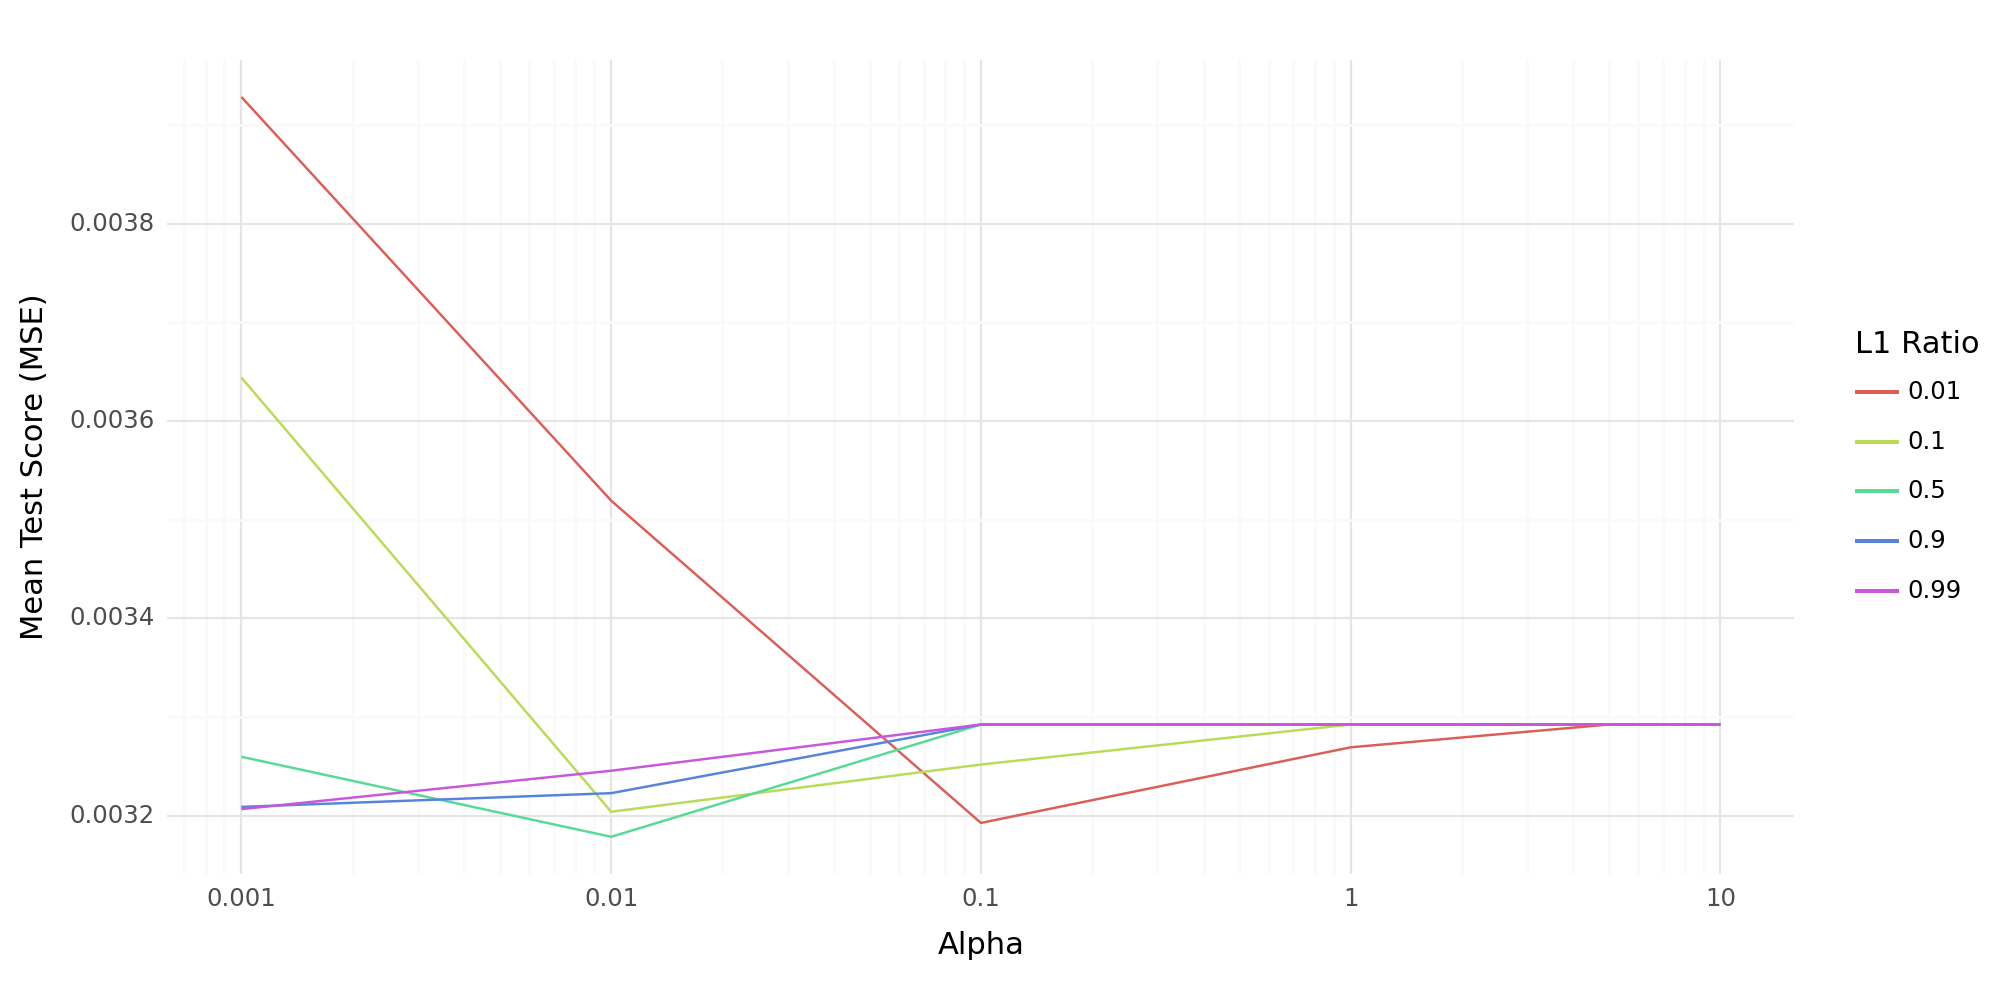

<Figure Size: (1000 x 500)>

In [196]:
(
    ggplot(data = grid_results ) 
    + aes(x="param_alpha", y="mean_test_score", color="param_l1_ratio") 
    + geom_line()           
    + theme_minimal()
    + scale_x_log10()
    + labs(
        x="Alpha",  
        y="Mean Test Score (MSE)", 
        color="L1 Ratio" 
      )
    + theme( figure_size=(10, 5))
)

The plot illustrates the mean test score (MSE) across various values of the regularization parameter alpha, combined with different L1 ratios ranging from 0.01 to 0.99 for the ElasticNet model. The results indicate that lower alpha values generally result in lower mean test scores, suggesting better model performance. Particularly, alpha values around 0.01 to 0.1 exhibit the lowest MSE across most L1 ratios.

The L1 ratio, which balances Lasso (L1) and Ridge (L2) regularization in the ElasticNet model, significantly impacts the MSE for alpha values below 0.1. For very low alpha values (0.001), models with higher L1 ratios (0.5, 0.9, and 0.99) show slightly lower MSE compared to those with lower L1 ratios (0.01 and 0.1). However, as alpha increases, the differences in MSE across various L1 ratios become negligible, indicating that at higher alpha values, the choice of L1 ratio is less critical to model performance.

The plot suggests that the best performance, indicated by the lowest MSE, is achieved with an alpha value around 0.1 and an L1 ratio of 0.5. This balance suggests that a mix of L1 and L2 regularization provides the most accurate forecasts, leveraging the strengths of both types of regularization. Higher alpha values, which increase the regularization effect, lead to higher MSE, highlighting the importance of not over-penalizing the model to avoid underfitting. Conversely, very low alpha values, especially with higher L1 ratios, can effectively control overfitting by selecting a simpler model with fewer predictors.

In summary, the optimal combination of alpha and L1 ratio for the ElasticNet model in this context appears to be around 0.1 for alpha and 0.5 for L1 ratio. This combination minimizes the mean test score (MSE), indicating a well-balanced model that effectively handles the trade-off between bias and variance.

### Variable Importance Plots

Lastly, we focus on identifying and visualizing the importance of predictors in our ElasticNet model. Understanding which variables are most influential in predicting the target outcome can provide valuable insights and help in refining the model further. Here's how we approach this analysis:

First, we extract the best model identified during the hyperparameter tuning process using grid.best_estimator_. This model has the optimal combination of alpha and L1 ratio that minimizes the mean squared error. Once we have this model, we obtain the coefficients of each predictor. The coefficients indicate the strength and direction of the relationship between the predictors and the target variable. In ElasticNet, the coefficients are influenced by both L1 and L2 regularization, which helps in selecting relevant predictors and reducing overfitting.

In [ ]:
# Get the best model
best_model = grid.best_estimator_

# Get coefficients
coefficients = best_model.coef_

Next, we prepare the data for plotting by creating a DataFrame with the features and their corresponding importance. The importance of each feature is determined by the absolute value of its coefficient. We then sort the features by their importance in descending order, retaining only those features with a non-zero importance.

To visualize the variable importance, we create a horizontal bar chart using plotnine. This plot provides a clear and intuitive way to see which predictors have the most significant impact on the model's predictions. The x-axis represents the features, while the y-axis shows their importance. By rotating the x-axis labels and flipping the coordinates, we ensure that the plot is easy to read and interpret.

This visualization helps us quickly identify the most influential predictors in our model, providing insights into the factors driving the predictions and guiding future model refinement and feature selection efforts.

In [197]:
# Prepare data for plotting
importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
importance = importance.sort_values(by='Importance', ascending=False)
importance = importance[importance['Importance'] > 0]s

In [198]:
importance

,Feature,Importance
22,pricedirection,0.007448
4,pessimism,0.000247
7,trust,0.000078


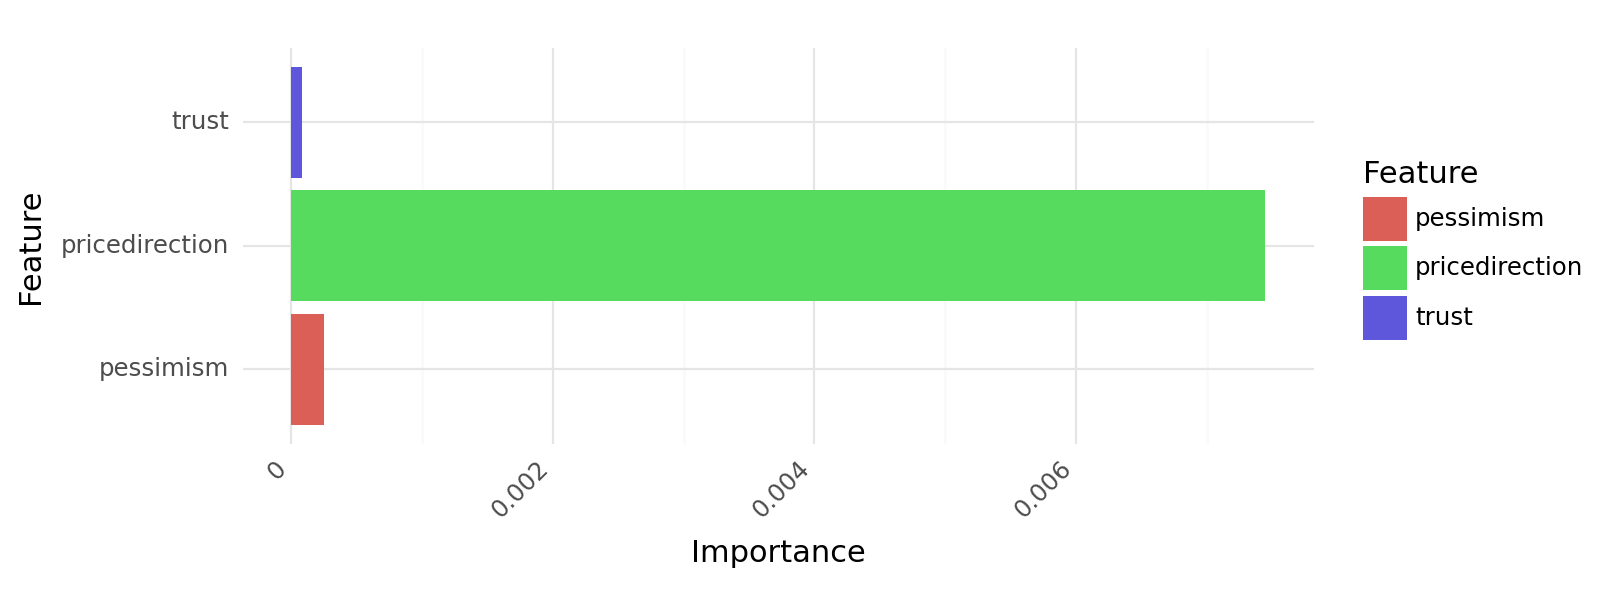

<Figure Size: (800 x 300)>

In [199]:
# Create horizontal bar chart for variable importance
(
    ggplot(importance, aes(x='Feature', y='Importance', fill='Feature')) 
    + geom_bar(stat='identity', position='dodge') 
    + theme_minimal()
    + theme(axis_text_x=element_text(rotation=45, hjust=1),  # Rotate x labels for better readability
          figure_size=(8, 3),) 
    + labs(x='Feature', y='Importance') 
    + coord_flip()  # Flip the coordinates to make it a horizontal bar chart
)

The variable importance plot generated from our ElasticNet model reveals the most influential predictors in forecasting the daily returns of Ethereum (ETH). The plot showcases three key features: trust, priceDirection, and pessimism, with varying levels of importance.

Among these predictors, priceDirection stands out as the most significant feature, with a notably higher importance value compared to the others. This indicates that references to price increases versus decreases in the marketpsych data are the strongest predictors of ETH daily returns. The substantial coefficient for priceDirection suggests that changes in market sentiment regarding price movements have a significant impact on the returns of Ethereum.

The trust feature, while still relevant, has a much smaller importance value. This predictor measures the net trustworthiness versus corruption references, and though it contributes to the model, its impact is considerably less pronounced than that of priceDirection.

Lastly, pessimism, which captures future-tense negative references, shows some importance but is the least influential among the three highlighted features. The negative coefficient implies that increased pessimistic sentiment slightly negatively affects ETH returns, but its impact is minimal compared to priceDirection.

Overall, the ElasticNet model identifies priceDirection as the dominant regressor, significantly correlated Ethereum's daily returns. Trust and pessimism also play roles, albeit to a lesser extent, providing a nuanced view of how different sentiments and market perceptions contribute to cryptocurrency price movements.

# Assignment

This is going to be your final weekly assignment!   

Use the replication dataset for Amini et al. (2021) provided here for this assignment: https://drive.google.com/file/d/1afHWBlRfBUO_GOQ5yQoeb8IaI8wQngTt/view?usp=sharing.    

The SSRN pre-print version of this paper contains a nice description of all the variables in the data set on pages 51-55 (note that the variables in the data set carry the same name, but are lower case in the file and upper case in the paper).

- Use ElasticNet to identify the most important predictors of capital structure.
- Show how different levels of hyperparameters impact target scores.
- Show which variables are most important, and interpret the results.

Amini, S., Elmore, R., Öztekin, Ö., & Strauss, J. (2021). Can machines learn capital structure dynamics?. Journal of Corporate Finance, 70, 102073.